<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/SIIM-ISIC%20Melanoma%20Classification/banner.png' height="350"></center>
<p>
<h1><center> SIIM-ISIC Melanoma Classification </center></h1>
<h2><center> Melanoma Classification - SHAP model explained </center></h2>
<p>

#### About SHAP from [the reposiroty](https://github.com/slundberg/shap)
<center><img src='https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png' width="500" height="150"></center>

#### SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

## Dependencies

In [1]:
!pip install --quiet image-classifiers

import warnings, json, re, glob, math, shutil, os, shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from classification_models.tfkeras import Classifiers

SEED = 0
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

# pre-process data
train['image_name'] = train['image_name'].apply(lambda x: x + '.jpg')
train['target'] = train['target'].astype(str)

GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-256x256')
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


## Parameters

In [3]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

# SHAP parameters
images_to_explain = ['ISIC_0074311.jpg', 'ISIC_0074542.jpg', 'ISIC_0075663.jpg', 'ISIC_0075914.jpg', 
                     'ISIC_0076262.jpg', 'ISIC_0082543.jpg', 'ISIC_0082934.jpg', 'ISIC_0083035.jpg', 
                     'ISIC_0084086.jpg', 'ISIC_0084270.jpg', 'ISIC_0149568.jpg', 'ISIC_0188432.jpg', 
                     'ISIC_0207268.jpg', 'ISIC_0232101.jpg', 'ISIC_0247330.jpg', 'ISIC_0528044.jpg', 
                     'ISIC_1219894.jpg', 'ISIC_2776906.jpg']

eval_df = train[train['image_name'].isin(images_to_explain)]

os.makedirs('to_explain/')
for filename in images_to_explain:
    shutil.copy('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/' + filename, 'to_explain/')

## Auxiliary functions

In [4]:
# Datasets utility functions
UNLABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "image_name": tf.io.FixedLenFeature([], tf.string), # shape [] means single element
    # meta features
    "patient_id": tf.io.FixedLenFeature([], tf.int64),
    "sex": tf.io.FixedLenFeature([], tf.int64),
    "age_approx": tf.io.FixedLenFeature([], tf.int64),
    "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

# Test function
def read_unlabeled_tfrecord(example, height=HEIGHT, width=WIDTH, channels=CHANNELS):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Custom SHAP plot
def image_plot(shap_values, pixel_values, labels=None, preds=None, names=None, width=20, aspect=0.2, hspace=0.2, labelpad=None, show=True, fig_size=None):
    """ Plots SHAP values for image inputs.
    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being explained.
    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
        shape as each array in the shap_values list of arrays.
    labels : list
        List of names for each of the model outputs that are being explained. This list should be the same length
        as the shap_values list.
    width : float
        The width of the produced matplotlib plot.
    labelpad : float
        How much padding to use around the model output labels.
    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    if fig_size is None:
        fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
        if fig_size[0] > width:
            fig_size *= width / fig_size[0]
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        axes[row,0].imshow(x_curr, cmap=plt.get_cmap('gray'))
        axes[row,0].set_title(f'Image: {names[row]}', **label_kwargs)
        axes[row,0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(f'Label: {labels[row,i]} Pred: {preds[row,i]:.2f}', **label_kwargs)
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row,i+1].imshow(sv, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
    cb.outline.set_visible(False)
    if show:
        plt.show()

# Model

### I will be using a ResNet18 model, trained with 3-Fold data.

In [5]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=input_shape, 
                          weights=None, 
                          include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

model = model_fn((HEIGHT, WIDTH, CHANNELS))
model.load_weights('/kaggle/input/shap-model/ResNet_18.h5') # load pre-trained weights
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Model)                (None, 8, 8, 512)         11186889  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 11,187,402
Trainable params: 11,179,460
Non-trainable params: 7,942
_________________________________________________________________


# First lets make the evaluated set predictions

In [6]:
# data generator
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_generator=eval_datagen.flow_from_dataframe(
    dataframe=eval_df,
    directory='to_explain/',
    x_col='image_name',
    y_col='target',
    class_mode='binary', 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    shuffle=False,
    seed=SEED)

# add predictions
eval_df['preds'] = model.predict(eval_generator)
display(eval_df.head())

Found 18 validated image filenames belonging to 2 classes.


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,preds
5,ISIC_0074311.jpg,IP_2950485,female,40.0,lower extremity,unknown,benign,0,0.040372
6,ISIC_0074542.jpg,IP_4698288,male,25.0,lower extremity,unknown,benign,0,0.033142
7,ISIC_0075663.jpg,IP_6017204,female,35.0,torso,unknown,benign,0,0.009852
8,ISIC_0075914.jpg,IP_7622888,male,30.0,torso,unknown,benign,0,0.034863
9,ISIC_0076262.jpg,IP_5075533,female,50.0,lower extremity,unknown,benign,0,0.064709


# SHAP model explainability

### For this experiment we will use `GradientExplainer`, below is an example from the Imagenet dataset applied to a VGG16 model.

#### The more `pink` each pixel is the more it contributes to the image being classified on a specific class, and the more `blue` it is more the pixel contributes for it not being of that class. 

![](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/gradient_imagenet_plot.png)

#### Above for the 1st image the beak and wings of the dowitcher had a big contribution on assigning it to the correct class, and for the 2nd image the face of the meerkat contributed a lot to correctly classify it, for those examples we can assume that the model is doing a good job.

# Below are the images that will be explained by SHAP, you can also see the label and the model's prediction for each image.

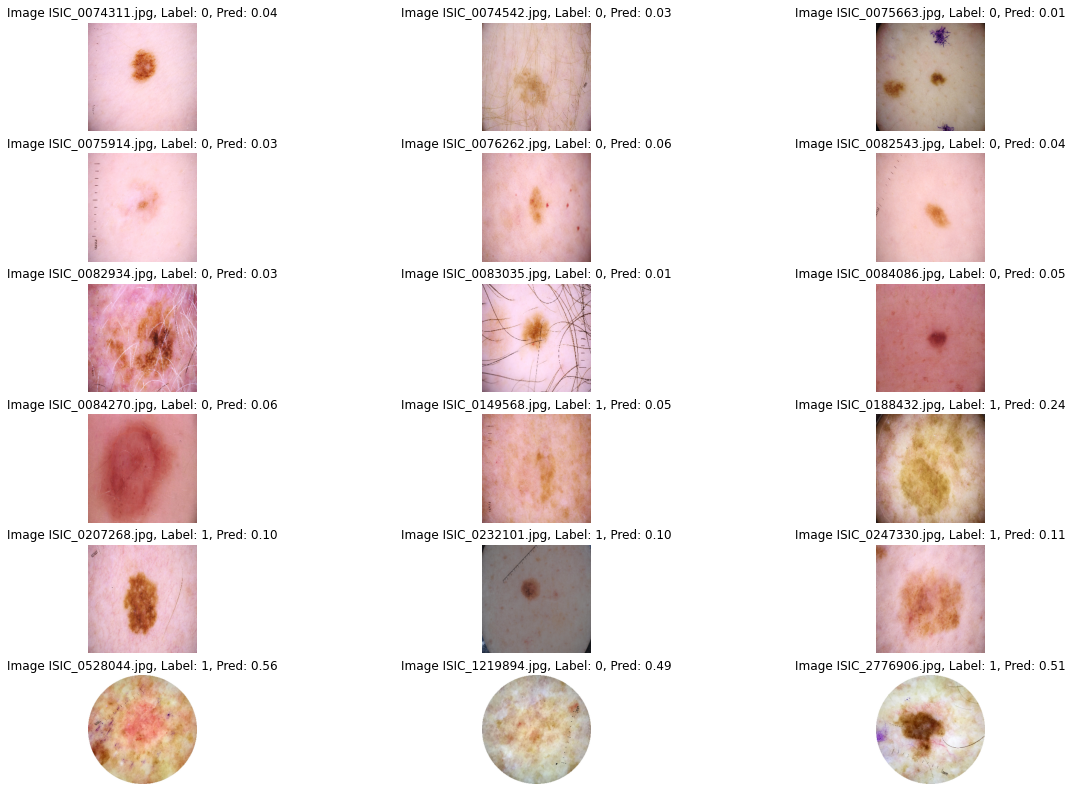

In [7]:
n_explain = 18
eval_generator.batch_size = n_explain # background dataset
background, lbls = next(eval_generator)
lbls = lbls.reshape(lbls.shape[0], 1)

fig, axes = plt.subplots(6, 3, figsize=(20, 14))
axes = axes.flatten()
for x in range(6):
    axes[x].imshow(background[x])
    axes[x+6].imshow(background[x+6])
    axes[x+12].imshow(background[x+12])
    
    axes[x].set_title(f"Image {eval_df['image_name'].values[x]}, Label: {eval_df['target'].values[x]}, Pred: {eval_df['preds'].values[x]:.2f}")
    axes[x+6].set_title(f"Image {eval_df['image_name'].values[x+6]}, Label: {eval_df['target'].values[x+6]}, Pred: {eval_df['preds'].values[x+6]:.2f}")
    axes[x+12].set_title(f"Image {eval_df['image_name'].values[x+12]}, Label: {eval_df['target'].values[x+12]}, Pred: {eval_df['preds'].values[x+12]:.2f}")
    
    axes[x].set_axis_off()
    axes[x+6].set_axis_off()
    axes[x+12].set_axis_off()
    
plt.show()

As we can see the model missed all the predictions that the label was 1, we will also see the explanation for those images.

# Using SHAP to explain the images

Using TensorFlow backend.


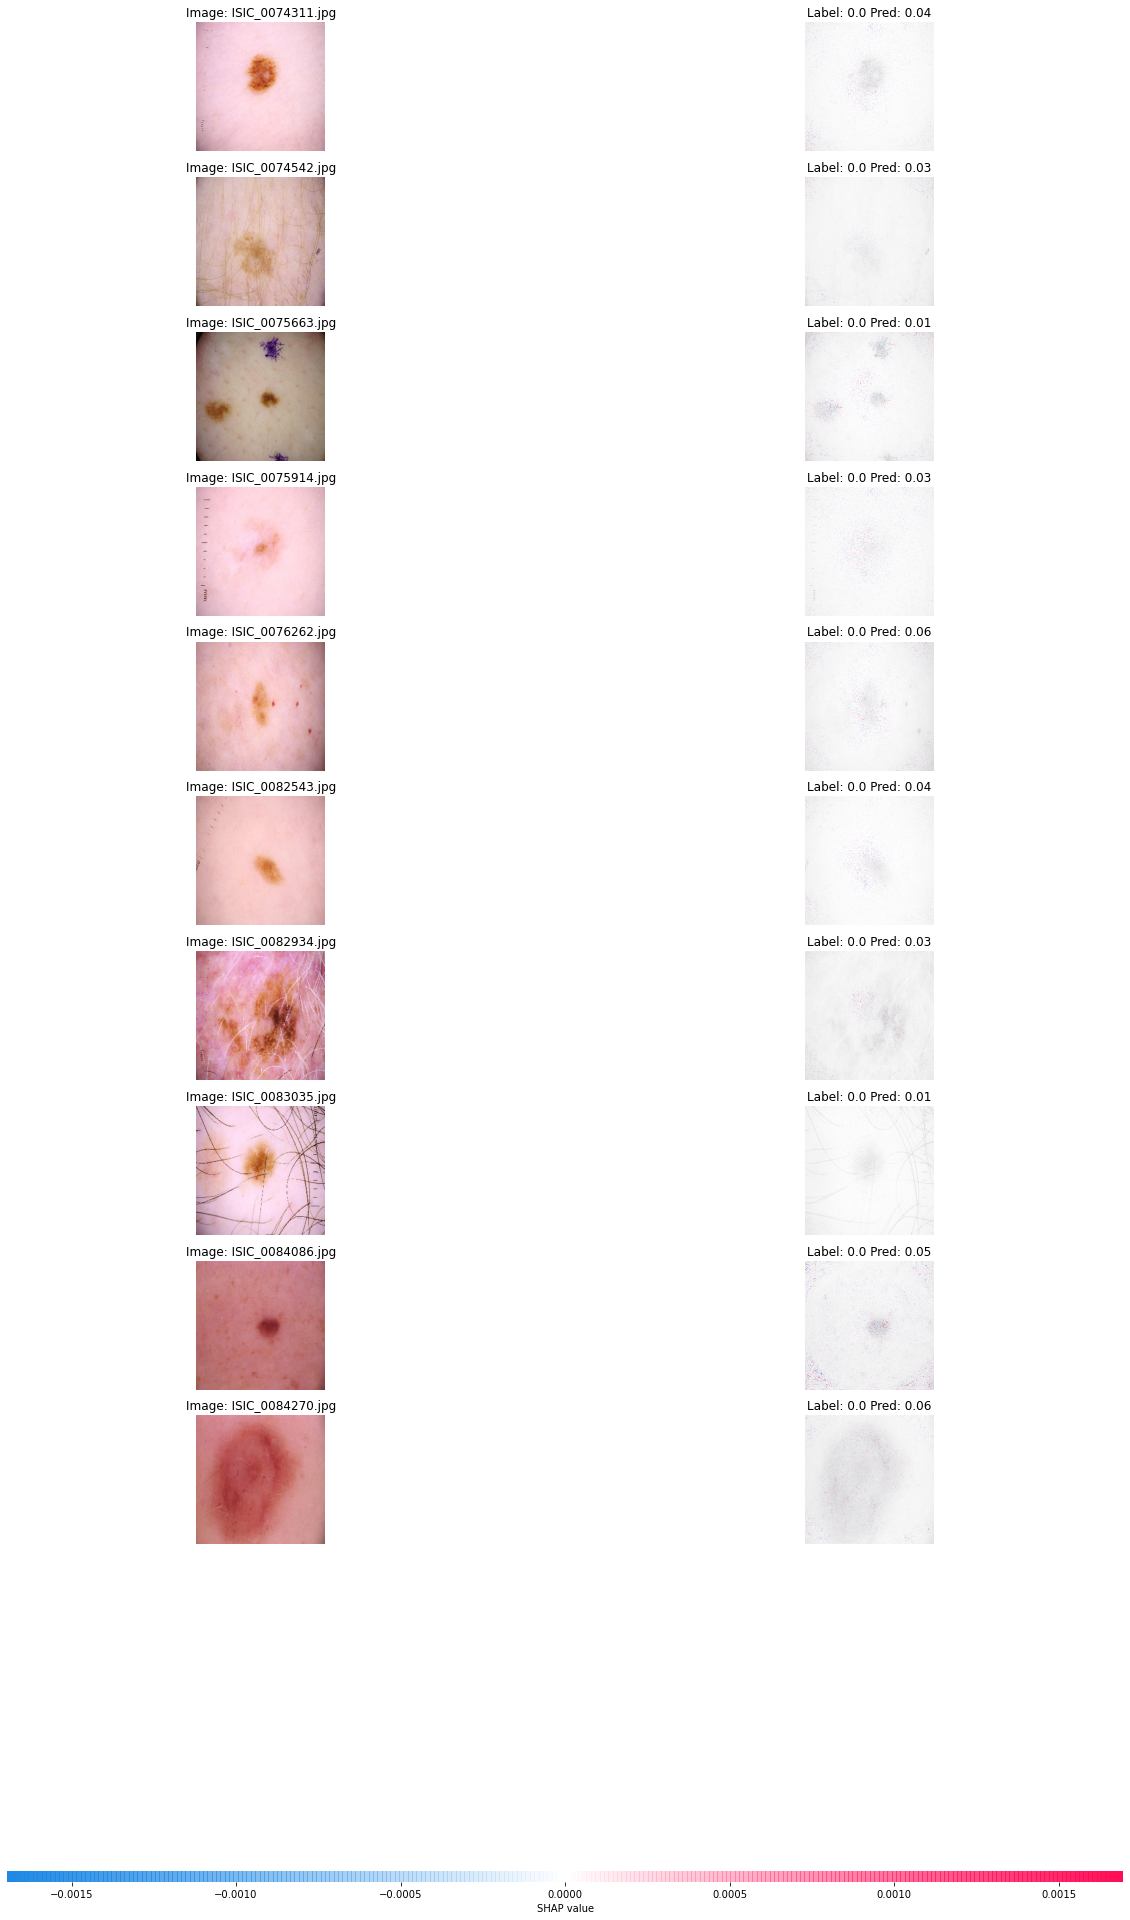

In [8]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
image_plot(shap_values, background[:10], labels=lbls, preds=eval_df['preds'].values[:10].reshape(10, 1), names=eval_df['image_name'].values[:10], 
           hspace=0.2, fig_size=(20, 40))

At all the above images the prediction score was very low, which resulted in the explained images (right images) being mostly gray, if you look really close, you may see some pink dots. At the same time, we can notice that at least the model pays attention mainly to the skin marks.

One interesting thing here is that the model seems to do not care about hair or the mm scale.

# Now the explanation for the positive images

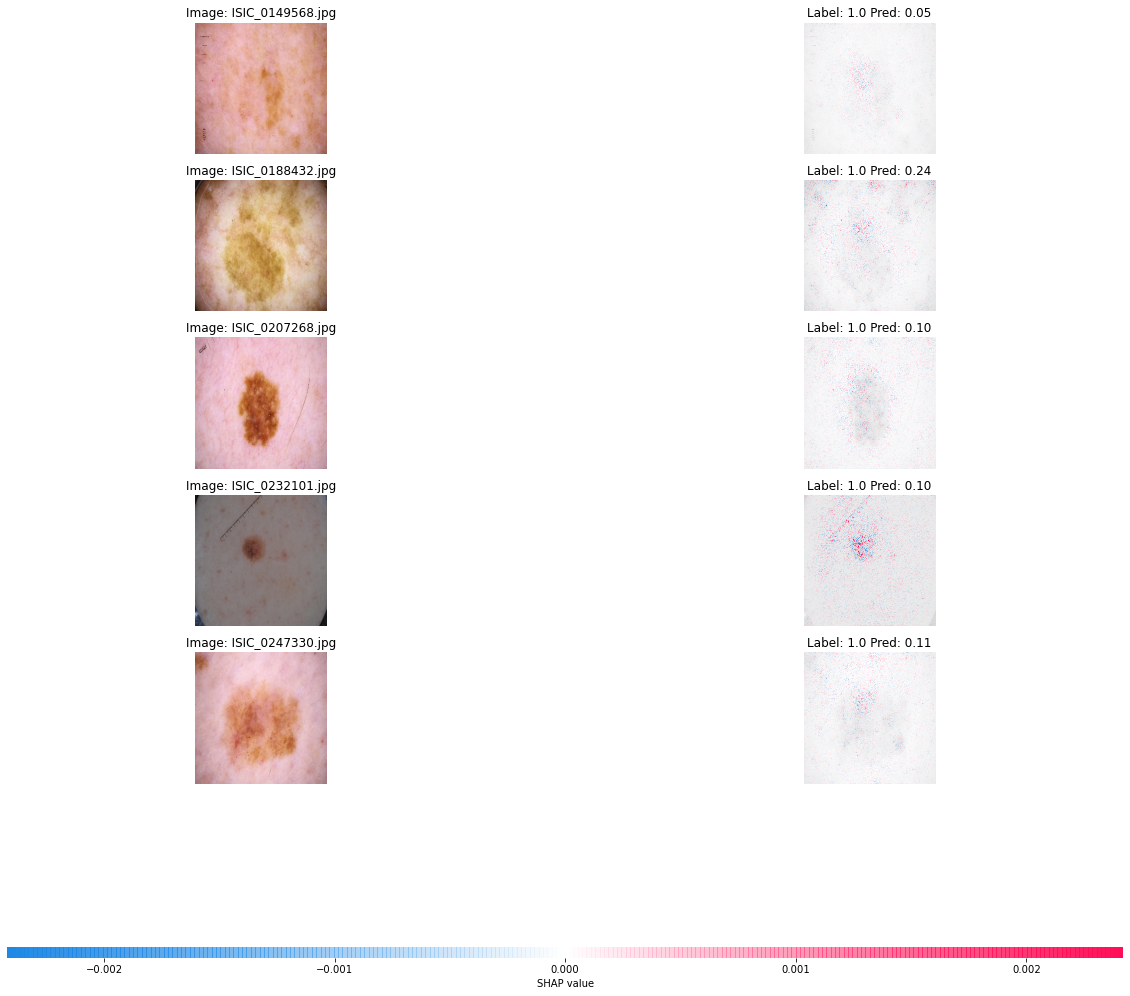

In [9]:
shap_values_positive = shap.GradientExplainer(model, background[10:15]).shap_values(background[10:15])

# plot the feature attributions
image_plot(shap_values_positive, background[10:15], labels=lbls[10:15], preds=eval_df['preds'].values[10:15].reshape(5, 1), 
           names=eval_df['image_name'].values[10:15], fig_size=(20, 20))

Here on the positive images you can see much more pink dots, they mean that those pixels contributed to the class 1 prediction, even if the model did not predicted the images as class 1, some part of the images weighted on that direction.

- In this 1st image the model really messed, it gave attention to a part of the image that did not even had a skin mark.
- At the 4th image (ISIC_0232101) the model gave some attention to the mm scale, and also scattered some attention across the image, not focussing on the skin marg too much.

### Looking at those images it is clear that the model has a lot to learn about the positive classes.

#### If you liked this experiment leave a comment below I may update it with a better model or make another version with both image and tabular data.

# Images that were predicted as postive or were very close

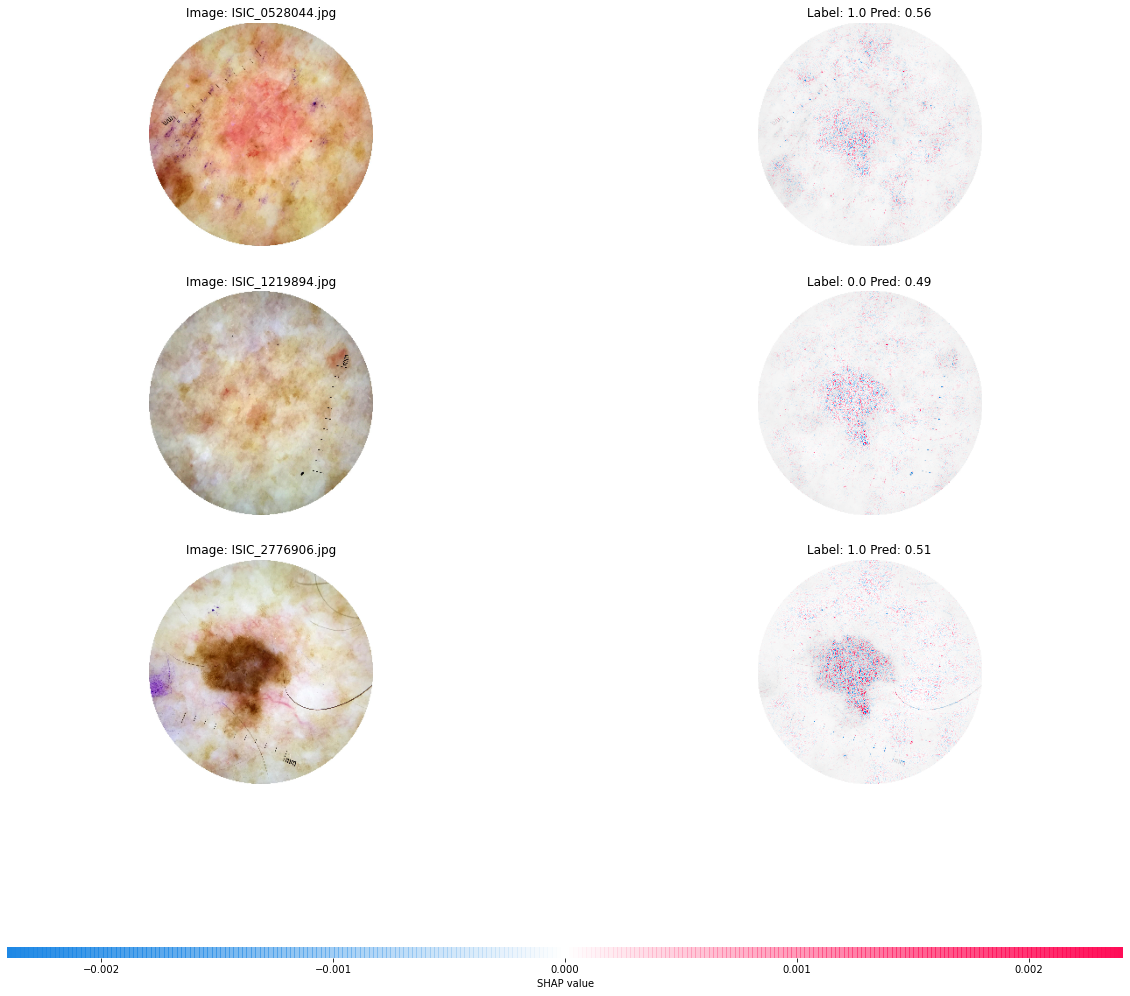

In [10]:
shap_values_positive = shap.GradientExplainer(model, background[-3:]).shap_values(background[-3:])

# plot the feature attributions
image_plot(shap_values_positive, background[-3:], labels=lbls[-3:], preds=eval_df['preds'].values[-3:].reshape(3, 1), 
           names=eval_df['image_name'].values[-3:], fig_size=(20, 20))

One very interesting part here is that the "microscope" effect does not seems to impact the predictions.

- On the 1st image the model focused more on the skin mark that was more red, and cared less about the brown mark at the side.
- This 2nd image is actually a negative sample but was almost predicted as positive, the model gave a lot of attention to the center.
- On the 3rd image that purple stain did not really mattered to the model.

It seems that the microscope augmentation that was suggested at the forum could be applied, at least this model did not use the circle to bias the prediction. Also, all 3 images had the `mm scale` but the model did not really care about it.

# Test set predictions

In [11]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=BATCH_SIZE, buffer_size=AUTO)
image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(len(test)))).numpy().astype('U')

test_preds = model.predict(test_dataset)

name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)


print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target']].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target']].query('target > .5').head(10))


submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)

Test predictions 12|10970
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.024403
1,ISIC_0052349,male,40.0,lower extremity,0.030373
2,ISIC_0058510,female,55.0,torso,0.021999
3,ISIC_0073313,female,50.0,torso,0.025697
4,ISIC_0073502,female,45.0,lower extremity,0.067994
5,ISIC_0074618,male,50.0,lower extremity,0.058979
6,ISIC_0076801,male,45.0,upper extremity,0.027755
7,ISIC_0077586,male,50.0,lower extremity,0.087986
8,ISIC_0082004,female,45.0,torso,0.064102
9,ISIC_0082785,male,65.0,lower extremity,0.046686


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
596,ISIC_0637104,female,80.0,torso,0.541949
1334,ISIC_1294368,female,35.0,torso,0.548455
1827,ISIC_1727295,female,70.0,torso,0.526034
2195,ISIC_2078598,male,80.0,torso,0.538988
2293,ISIC_2170268,female,80.0,upper extremity,0.647193
3034,ISIC_2828156,female,80.0,lower extremity,0.620550
3103,ISIC_2900150,female,80.0,lower extremity,0.541947
3125,ISIC_2922450,male,80.0,torso,0.557759
4332,ISIC_4000026,male,90.0,torso,0.530555
5412,ISIC_4965292,female,80.0,upper extremity,0.570446
